# Gedwongen oscilaties en resonantie

### Importeren packages

In [1]:
import numpy as np
import scipy.stats as nst
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import pandas as pd
import fit_routine as ft
sp.init_printing()

In [2]:
plt.style.use("lab")

In [3]:
#
# hulpfuncties voor de fit-functie
#

# functie die de Least-squares functie uitrekent
# f is de te fitten functie, x en y de gemeten waardes met sigma de fout op
# y (normaal verdeeld). theta zijn de parameters voor f 
# die geoptimaliseerd moeten worden
def LS(theta, f, x, y, sigma):
    return sum([(y[i] - f(x[i], *theta))**2/sigma[i]**2 for i in range(len(x))])

# minimaliseert de least-squares functie om de optimale 
# parameters theta voor f te vinden
# zodat f een zo goed mogelijke fit is door de datapunten (x_i, y_i)
def find_theta(f, theta0, x, y, sigma):
    return opt.minimize(LS, theta0, args=(f, x, y, sigma))

# de functie die van LS een functie maakt in 1 variabele, -val zodat de punten
# waar LS gelijk is aan val nulpunten worden
def LS_i(t, LS, theta, index, val, kwargs):
    dt = np.zeros_like(theta)
    dt[index] = t
    return LS(theta+dt, **kwargs) - val

# zoekt de standaardafwijkingen op theta_index in de functie chi
# van de minimale waarde chi(theta)
def find_sigma(chi, theta, index, f, x, y, sigma, delta, val):
    # los de vergelijking op
    args = (chi, theta, index, val, {"f": f, "x": x, "y": y, "sigma": sigma})
    dt1 = opt.fsolve(LS_i, delta, args=args)
    dt2 = opt.fsolve(LS_i, -delta, args=args)
    return (dt2, dt1)

# ------------------------------------------------------------------------------
# de fit functie

# fit de functie f door de datapunten (x_i, y_i) met fout dy op y 
# met de least-squares methode. theta0 is een eerste gok voor de parameters
# van f. delta is een gok op de procentuele afwijking
# van de gefitte parameters (array met zelfde dimensies als theta0)
def fit_function(f, x, y, dy, theta0, delta):
    # zoek de optimale waarde voor theta
    theta = find_theta(f=f, theta0=theta0, x=x, y=y, sigma=dy)
    minimum = theta['fun']
    # bereken de fout op theta
    sigma = [find_sigma(LS, theta['x'], index=i, f=f, x=x, y=y, sigma=dy, 
                        delta=delta[i]*theta['x'][i], val=minimum+1)\
             for i in range(len(theta['x']))]
    
    # bereken de p-waarde van de fit
    vrijheid = len(x)-len(theta0)
    p = 1-nst.chi2.cdf(theta['fun'], vrijheid)
    return {'param' : theta['x'], 'stdv' : sigma, 'p' : p}

## Voorbereidende opgaves

**Vraag 1: herschrijven uitdrukkingen**

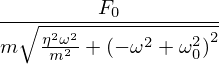

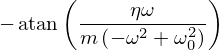

In [4]:
F0, m, omega0, omega, eta, k = sp.symbols("F0, m, omega0, omega, eta, k")
a_xw = F0/(m*sp.sqrt((omega0**2-omega**2)**2 + (omega*eta/m)**2))
var_a = [omega, omega0, m, eta, F0]
display(a_xw)
phi_w = -sp.atan((omega*eta/m)/(omega0**2-omega**2))
var_phi = [omega, omega0, m, eta]
display(phi_w)

In [5]:
phi, A, X, w, b = sp.symbols('phi, A, X, w, b')
eqA = sp.Eq(a_xw, A)
eqphi = sp.Eq(phi_w, phi)
eq1 = sp.Eq(X, F0/k)
eq2 = sp.Eq(w, omega/omega0)
eq3 = sp.Eq(b, eta/sp.sqrt(2*k*m))
eq4 = sp.Eq(omega0, sp.sqrt(k/m))

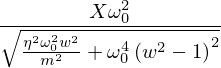

In [6]:
sols = sp.solve([eqA, eq1, eq2, eq3, eq4])
sols = sols[0]
sp.simplify(sols[A])

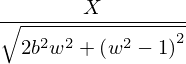

In [7]:
A_dim = X/sp.sqrt(2*w**2*b**2 + (w**2-1)**2)
display(A_dim)

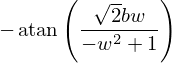

In [8]:
phi_dim = -sp.atan(sp.sqrt(2)*b*w/(1-w**2))
display(phi_dim)

Er treedt amplitude-resonantie op wanneer $w=1$, dus als $\omega = \omega_0$

### plots dimensieloze functies

In [9]:
# maak numerieke functies van de dimensiloze functies
A_dim_num = sp.lambdify([X, w, b], A_dim, "numpy")
phi_dim_num = sp.lambdify([X, w, b], phi_dim, "numpy")

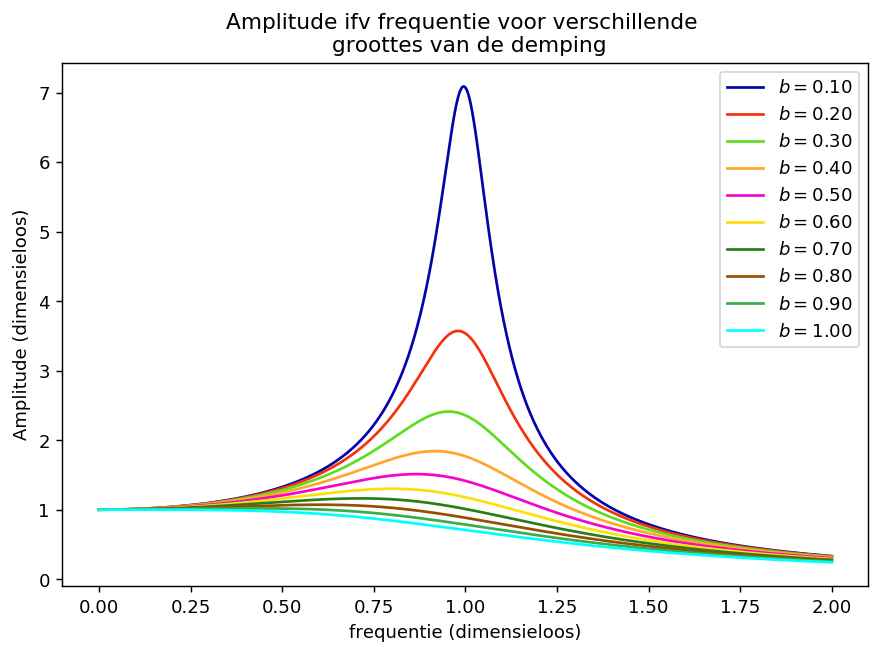

In [10]:
# definieer bereiken om te plotten
W = np.linspace(0, 2, 2000)
B = [(i+1)/10 for i in range(10)]
A_arr = [A_dim_num(1, W, demping) for demping in B]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(10):
    #ax = fig.add_subplot(5,2,i+1)
    ax.plot(W, A_arr[i], label="$b=%.2f$" %((i+1)/10))
    
ax.set_xlabel("frequentie (dimensieloos)")
ax.set_ylabel("Amplitude (dimensieloos)")
plt.title("Amplitude ifv frequentie voor verschillende \n groottes van de demping")
plt.legend()
    
plt.show()

In [11]:
# functie die atan2 gebruikt voor berekenen inverse tangens
def phi_atan2(X, w, b):
    return -np.arctan2(-np.sqrt(2)*b*w, -1+w**2)

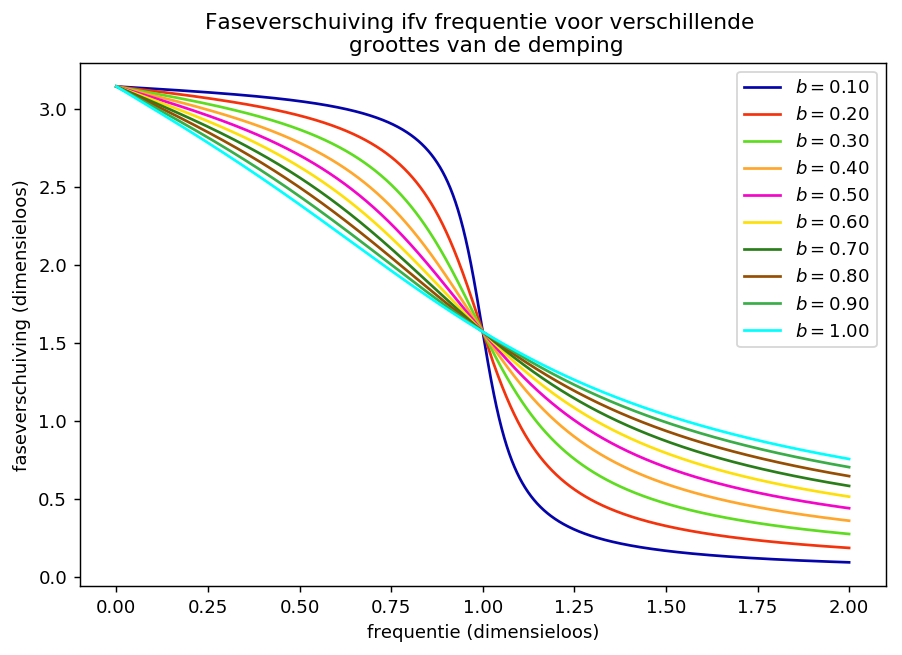

In [12]:
# definieer bereiken om te plotten
W = np.linspace(0, 2, 2000)
B = [(i+1)/10 for i in range(10)]
A_arr = [phi_atan2(1, W, demping) for demping in B]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(10):
    #ax = fig.add_subplot(5,2,i+1)
    ax.plot(W, A_arr[i], label="$b=%.2f$" %((i+1)/10))
    
ax.set_xlabel("frequentie (dimensieloos)")
ax.set_ylabel("faseverschuiving (dimensieloos)")
plt.title("Faseverschuiving ifv frequentie voor verschillende \n groottes van de demping")
plt.legend()
    
plt.show()

## Data practicum

In [13]:
df_small_res = pd.read_excel("Data_gedwongen_oscillator.xlsx")
df_big_res = pd.read_excel("Data_gedwongen_oscillatie_schijf.xlsx")
dsys_A = 0.002
dsys_fase = 1*np.pi/180

### De te fitten functies en methodes om te fitten

In [14]:
f_A = sp.lambdify(var_a, a_xw, "numpy")
def f_phi(omega, omega0, m, eta):
    return np.arctan2(eta*omega, -m*(omega**2-omega0**2))

In [15]:
# de volgorde van de parameters
display(var_a, var_phi)

In [16]:
# de keys in het dataframe
df_small_res.columns

Index(['frequentie [Hz]', 'SD freq', 'Amplitude [mm]', 'SD Amp', 'fase[°]',
       'SD fase'],
      dtype='object')

### Fits kleine weerstand

transformeer de data naar numpy arrays

In [17]:
df_small_res.columns

Index(['frequentie [Hz]', 'SD freq', 'Amplitude [mm]', 'SD Amp', 'fase[°]',
       'SD fase'],
      dtype='object')

In [18]:
df = df_small_res
f = df['frequentie [Hz]'].values
omega = 2*np.pi*f
domega = 2*np.pi*df["SD freq"]
domega = np.maximum(domega, 2*np.pi*0.01*np.ones_like(domega))
# Amplitude en fouten hierop, verander de eenheid naar meter
A = df['Amplitude [mm]'].values
A *= 0.001
# voeg ook de systematische fout toe aan de fout op de amplitude
dA = df['SD Amp'].values
dA *= 0.001
dA = np.maximum(dA, dsys_A*np.ones_like(dA))
# de faseverschuiving en de fout hierop, verander naar radialen
fase = df['fase[°]']
fase *= np.pi/180
dfase = df['SD fase']
dfase *= np.pi/180
dfase = np.maximum(dfase, dsys_fase/np.sqrt(12)*np.ones_like(dfase))

In [19]:
fit = ft.fit(f_A, omega, A, dA, (11, 10, 10, 10), (0.01, 0.01, 0.01, 0.01))

In [20]:
for i in range(len(fit['param'])):
    display("%s: %f +- %f" %(str(var_a[i+1]), fit['param'][i], fit['stdv'][i][0][0]))

'omega0: 11.338502 +- -0.008253'

'm: 12.052264 +- -0.217224'

'eta: 8.307703 +- -0.088747'

'F0: 8.513498 +- -0.069264'

In [21]:
def dphi(x, a, b, c, d):
    return f_phi(x, a, b, c) - d
fit_fase = ft.fit(f_phi, omega, fase, dfase, (11, 8, 3.7), (0.01, 0.01, 0.01))
fit_fase2 = ft.fit(dphi, omega, fase, dfase, (11, 8, 3.7, -0.4), (0.01, 0.01, 0.01, 0.01))

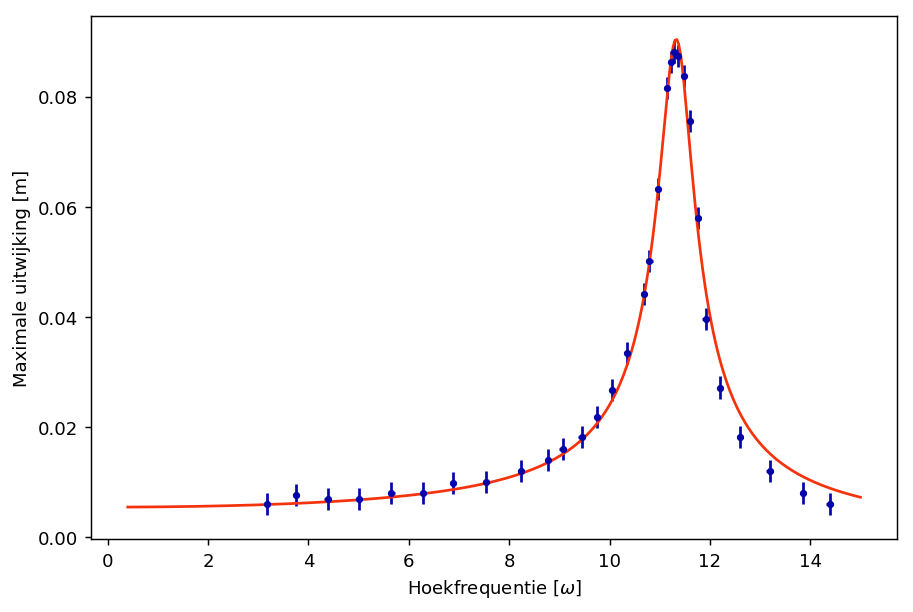

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.errorbar(omega, A, dA, domega, fmt='.')
X = np.linspace(0.4, 15, 400)
Y = [f_A(x, *fit['param']) for x in X]
ax.plot(X, Y)
#X = np.linspace(0.4, 15, 400)
#Y = [f_A(x, *fit_fase['param'], fit['param'][-1]) for x in X]
#ax.plot(X, Y)
#X = np.linspace(0.4, 15, 400)
#Y = [f_A(x, *fit_fase2['param'][:-1], fit['param'][-1]) for x in X]
#ax.plot(X, Y)

ax.set_xlabel("Hoekfrequentie [$\omega$]")
ax.set_ylabel("Maximale uitwijking [m]")

plt.show()

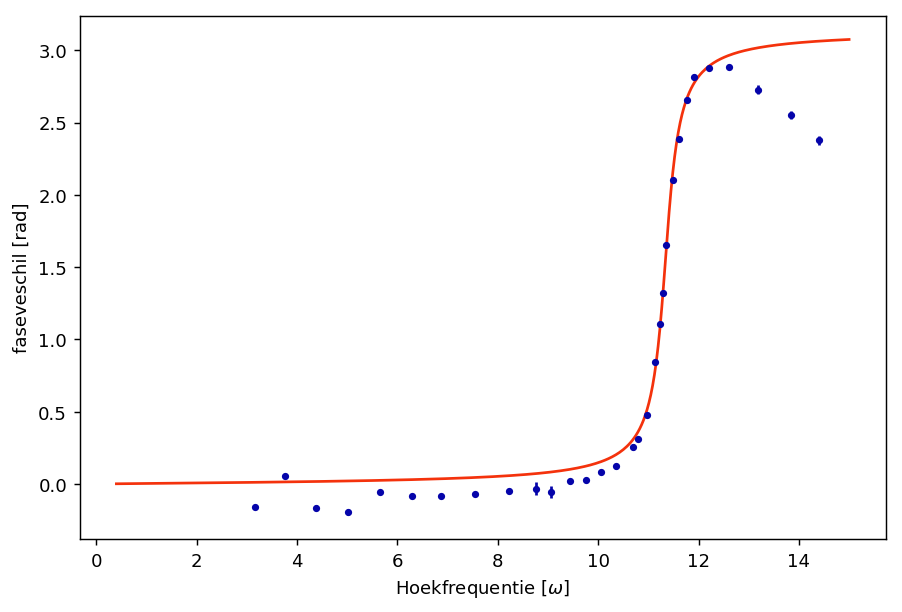

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.errorbar(omega, fase, dfase, fmt='.')
X = np.linspace(0.4, 15, 400)
Y = [f_phi(x, *fit_fase['param']) for x in X]
ax.plot(X, Y)
#X = np.linspace(0.4, 15, 400)
#Y = [f_phi(x, *fit['param'][:-1]) for x in X]
#ax.plot(X, Y)
#X = np.linspace(0.4, 15, 400)
#Y = [dphi(x, *fit_fase2['param']) for x in X]
#ax.plot(X, Y)

ax.set_xlabel("Hoekfrequentie [$\omega$]")
ax.set_ylabel("faseveschil [rad]")

plt.show()

In [24]:
fit_fase

{'param': array([11.34514025,  6.49392627,  2.76762079]),
 'stdv': [(array([-0.00139156]), array([0.0013946])),
  (array([-0.05030217]), array([0.05073805])),
  (array([-0.02145621]), array([0.02160544]))],
 'p': 0.0}

In [25]:
fit

{'param': array([11.3385019 , 12.05226361,  8.3077027 ,  8.51349807]),
 'stdv': [(array([-0.00825258]), array([0.00820997])),
  (array([-0.21722424]), array([0.22204495])),
  (array([-0.08874717]), array([0.09032475])),
  (array([-0.06926395]), array([0.06926395]))],
 'p': 0.03663749418924045}

In [26]:
fit_fase2

{'param': array([11.31364883,  3.44767227,  1.5675832 ,  0.09869686]),
 'stdv': [(array([-0.00134188]), array([0.00134458])),
  (array([-0.02780975]), array([0.02804986])),
  (array([-0.01265075]), array([0.01274732])),
  (array([-0.00193603]), array([0.00193604]))],
 'p': 0.0}

### Fits grote weerstand

transformeer de data naar numpy arrays

In [27]:
df = df_big_res
f = df['Frequentie [Hz]'].values
omega = 2*np.pi*f
# Amplitude en fouten hierop, verander de eenheid naar meter
A = df['Amplitude [mm]'].values
A *= 0.001
# voeg ook de systematische fout toe aan de fout op de amplitude
dA = df['SD Amp [mm]'].values
dA *= 0.001
dA = np.maximum(dA, dsys_A*np.ones_like(dA))
# de faseverschuiving en de fout hierop, verander naar radialen
fase = df['Fase [°]']
fase *= np.pi/180
dfase = df['SD Fase [°]']
dfase *= np.pi/180
dfase = np.maximum(dfase, dsys_fase*np.ones_like(dfase))

In [28]:
fit = ft.fit(f_A, omega, A, dA, (10, 10, 10, 10), (0.01, 0.01, 0.01, 0.01))

In [29]:
for i in range(len(fit['param'])):
    display("%s: %f +- %f" %(str(var_a[i+1]), fit['param'][i], fit['stdv'][i][0][0]))

'omega0: 10.876109 +- -0.038287'

'm: 2.811483 +- -0.037499'

'eta: 15.735393 +- -0.129366'

'F0: 10.259011 +- -0.063170'

In [30]:
def dphi(x, a, b, c, d):
    return f_phi(x, a, b, c) - d
fit_fase = ft.fit(f_phi, omega, fase, dfase, (11, 8, 3.7), (0.01, 0.01, 0.01))
fit_fase2 = ft.fit(dphi, omega, fase, dfase, (11, 8, 3.7, -0.4), (0.01, 0.01, 0.01, 0.01))

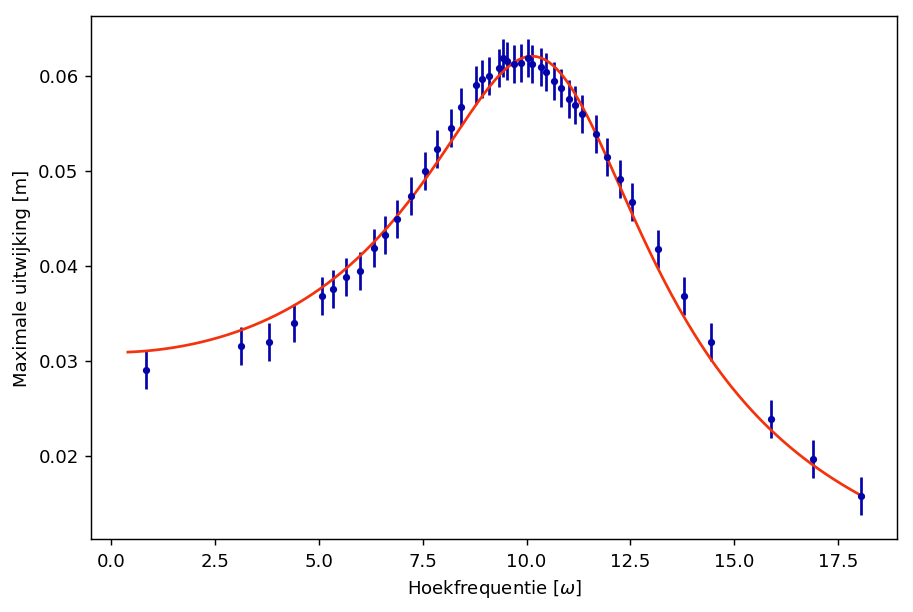

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.errorbar(omega, A, dA, fmt='.')
X = np.linspace(0.4, 18, 400)
Y = [f_A(x, *fit['param']) for x in X]
ax.plot(X, Y)
X = np.linspace(0.4, 18, 400)
Y = [f_A(x, *fit_fase['param'], fit['param'][-1]) for x in X]
#ax.plot(X, Y)
X = np.linspace(0.4, 18, 400)
Y = [f_A(x, *fit_fase2['param'][:-1], fit['param'][-1]) for x in X]
#ax.plot(X, Y)

ax.set_xlabel("Hoekfrequentie [$\omega$]")
ax.set_ylabel("Maximale uitwijking [m]")

plt.show()

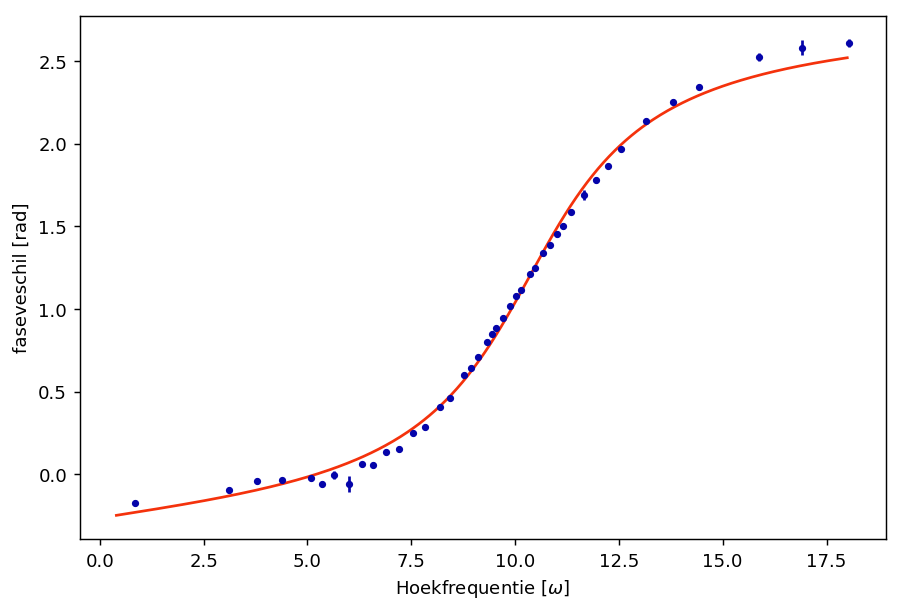

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.errorbar(omega, fase, dfase, fmt='.')
X = np.linspace(0.4, 18, 400)
Y = [f_phi(x, *fit_fase['param']) for x in X]
#ax.plot(X, Y)
X = np.linspace(0.4, 18, 400)
Y = [f_phi(x, *fit['param'][:-1]) for x in X]
#ax.plot(X, Y)
X = np.linspace(0.4, 18, 400)
Y = [dphi(x, *fit_fase2['param']) for x in X]
ax.plot(X, Y)

ax.set_xlabel("Hoekfrequentie [$\omega$]")
ax.set_ylabel("faseveschil [rad]")

plt.show()

In [33]:
fit_fase

{'param': array([11.35468876,  1.80895107,  7.62495894]),
 'stdv': [(array([-0.01014432]), array([0.01016])),
  (array([-0.01287325]), array([0.01297271])),
  (array([-0.05429228]), array([0.0546513]))],
 'p': 0.0}

In [34]:
fit

{'param': array([10.87610906,  2.81148279, 15.735393  , 10.25901061]),
 'stdv': [(array([-0.03828708]), array([0.03835242])),
  (array([-0.03749889]), array([0.03812804])),
  (array([-0.12936605]), array([0.13109707])),
  (array([-0.06317014]), array([0.06317013]))],
 'p': 0.998316484496763}

In [35]:
fit_fase2

{'param': array([10.59065006,  2.89790823, 12.79302288,  0.26408431]),
 'stdv': [(array([-0.00956927]), array([0.00957484])),
  (array([-0.02196926]), array([0.022137])),
  (array([-0.0969845]), array([0.09772572])),
  (array([-0.00280095]), array([0.00280097]))],
 'p': 0.0}